In [2]:
import pandas as pd
import numpy as np
import faiss
import datetime

In [1]:
from binance.client import Client
import requests
import pandas as pd
import datetime
import time

# --- Configuration ---
SYMBOL = 'ADAUSDT'
TARGET_DATE = datetime.datetime(2025, 12, 27)
TOTAL_ROWS_NEEDED = 15000
BATCH_LIMIT = 1000  # Safe limit per request for Binance API
INTERVAL = Client.KLINE_INTERVAL_15MINUTE

kline_columns = [
    'timestamp', 'open', 'high', 'low', 'close', 'volume', 
    'Close Time', 'Quote Asset Volume', 'Number of Trades', 
    'Taker Buy Base', 'Taker Buy Quote', 'Ignore'
]

def fetch_batch(symbol, interval, end_time_ms, limit):
    """Helper function to fetch a single batch of data"""
    params = {
        "symbol": symbol.upper(),
        "interval": interval,
        "limit": limit,
        "endTime": end_time_ms
    }
    try:
        response = requests.get("https://fapi.binance.com/fapi/v1/klines", params=params)
        response.raise_for_status() # Check for HTTP errors
        return response.json()
    except Exception as e:
        print(f"Request failed: {e}")
        return []

def get_historical_data(symbol, target_date, total_rows, interval):
    all_kline_data = []
    
    # Start from the target date (converted to milliseconds)
    current_end_time = int(target_date.timestamp() * 1000)
    
    rows_fetched = 0
    
    print(f"Fetching {total_rows} rows for {symbol}...")
    
    while rows_fetched < total_rows:
        # Calculate how many rows we still need for this batch
        remaining = total_rows - rows_fetched
        # Don't ask for more than the API allows (BATCH_LIMIT)
        limit = min(remaining, BATCH_LIMIT)
        
        batch_data = fetch_batch(symbol, interval, current_end_time, limit)
        
        if not batch_data:
            print("No more data received or error occurred.")
            break
            
        # Binance returns data [oldest -> newest]. 
        # Since we are going backward in time, we prepend this batch to our main list.
        all_kline_data = batch_data + all_kline_data
        
        rows_fetched += len(batch_data)
        print(f"Fetched {len(batch_data)} rows. Total: {rows_fetched}/{total_rows}")
        
        # IMPORTANT: Set the endTime for the next loop to be just BEFORE
        # the oldest candle we just fetched.
        oldest_timestamp_in_batch = batch_data[0][0]
        current_end_time = oldest_timestamp_in_batch - 1
        
        # Sleep briefly to avoid hitting Binance rate limits (IP ban risk)
        time.sleep(0.1)

    df = pd.DataFrame(all_kline_data, columns=kline_columns)
    
    # Format timestamp
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    return df

# --- Execution ---
df = get_historical_data(SYMBOL, TARGET_DATE, TOTAL_ROWS_NEEDED, INTERVAL)

print("\nFinal Result:")
print(f"Total rows: {len(df)}")

if not df.empty:
    print(f"Start Date: {df['timestamp'].iloc[0]}")
    print(f"End Date:   {df['timestamp'].iloc[-1]}")
    df.to_csv('data_15000.csv', index=False)

Fetching 15000 rows for ADAUSDT...
Fetched 1000 rows. Total: 1000/15000
Fetched 1000 rows. Total: 2000/15000
Fetched 1000 rows. Total: 3000/15000
Fetched 1000 rows. Total: 4000/15000
Fetched 1000 rows. Total: 5000/15000
Fetched 1000 rows. Total: 6000/15000
Fetched 1000 rows. Total: 7000/15000
Fetched 1000 rows. Total: 8000/15000
Fetched 1000 rows. Total: 9000/15000
Fetched 1000 rows. Total: 10000/15000
Fetched 1000 rows. Total: 11000/15000
Fetched 1000 rows. Total: 12000/15000
Fetched 1000 rows. Total: 13000/15000
Fetched 1000 rows. Total: 14000/15000
Fetched 1000 rows. Total: 15000/15000

Final Result:
Total rows: 15000
Start Date: 2025-07-23 11:15:00
End Date:   2025-12-26 17:00:00


In [4]:
# --- CONFIGURATION ---
CSV_FILE = 'data.csv'   # Must have columns: ['timestamp', 'open', 'high', 'low', 'close']
WINDOW_SIZE = 60        # Look back 60 candles (e.g., 60 hours)
PREDICTION_HORIZON = 12 # Look forward 12 candles for the "Outcome"
TOP_K = 5               # How many similar historical matches to find

In [ ]:
class TimeSeriesRAG:
    def __init__(self, window_size=60):
        self.window_size = window_size
        self.dimension = window_size  # The vector dimension is the window size
        self.index = faiss.IndexFlatL2(self.dimension) # L2 Distance = Euclidean Distance
        self.metadata = {} # Stores dates and outcomes for each vector
        self.data = None

    def normalize_window(self, window_data):
        """
        Normalizes a window of prices to be Percentage Change from the start.
        This makes the vector 'price-agnostic' (matches shapes, not dollar values).
        """
        start_price = window_data[0]
        if start_price == 0: 
            return np.zeros_like(window_data)
        
        # Formula: (Current_Price / Start_Price) - 1
        return (window_data / start_price) - 1

    def ingest_data(self, filepath):
        print(f"Loading data from {filepath}...")
        df = pd.read_csv(filepath)
        
        # Ensure 'close' is float
        df['close'] = df['close'].astype(float)
        self.data = df
        
        vectors = []
        vector_ids = []
        
        # Create sliding windows
        # We stop early so we have data for the PREDICTION_HORIZON
        count = 0
        for i in range(len(df) - self.window_size - PREDICTION_HORIZON):
            # 1. Capture the Window (The "Question")
            window = df['close'].values[i : i + self.window_size]
            norm_vector = self.normalize_window(window)
            
            # 2. Capture the Outcome (The "Answer")
            current_price = df['close'].values[i + self.window_size - 1]
            future_price = df['close'].values[i + self.window_size + PREDICTION_HORIZON - 1]
            
            # Outcome: Return over the next 12 candles
            future_return = (future_price - current_price) / current_price
            
            # 3. Store
            vectors.append(norm_vector)
            self.metadata[count] = {
                "date": df.iloc[i + self.window_size]['timestamp'],
                "outcome_return": future_return,
                "close_price": current_price
            }
            count += 1
            
        # Bulk add to FAISS
        if vectors:
            vectors_np = np.array(vectors).astype('float32')
            self.index.add(vectors_np)
            print(f"Successfully indexed {self.index.ntotal} historical market patterns.")
        else:
            print("Error: Not enough data to create windows.")

    def retrieve(self, current_window_data, time_threshold_hours=4):
        """
        Retrieves top K matches but prevents selecting overlapping time windows.
        """
        # 1. Search for more candidates than we need (e.g., Top 20 instead of Top 5)
        query_vector = self.normalize_window(current_window_data).reshape(1, -1).astype('float32')
        distances, indices = self.index.search(query_vector, k=20)
        
        unique_results = []
        seen_timestamps = []

        for i, idx in enumerate(indices[0]):
            if idx == -1: 
                continue
            
            match_date_str = self.metadata[idx]['date']
            match_date = datetime.datetime.strptime(match_date_str, "%Y-%m-%d %H:%M:%S")
            
            # 2. Check for Time Conflict
            is_redundant = False
            for seen_date in seen_timestamps:
                # Calculate absolute difference in hours
                diff = abs((match_date - seen_date).total_seconds()) / 3600
                if diff < time_threshold_hours:
                    is_redundant = True
                    break
            
            # 3. Add only if unique
            if not is_redundant:
                unique_results.append({
                    "similarity_score": distances[0][i],
                    "historical_date": match_date_str,
                    "future_return": self.metadata[idx]['outcome_return']
                })
                seen_timestamps.append(match_date)
                
            # Stop once we have enough unique matches
            if len(unique_results) >= TOP_K:
                break
                
        return unique_results
    
    def retrieve_with_data(self, current_window_data):
        # ... (Standard search code) ...
        query_vector = self.normalize_window(current_window_data).reshape(1, -1).astype('float32')
        distances, indices = self.index.search(query_vector, TOP_K)
        
        results = []
        for i, idx in enumerate(indices[0]):
            if idx == -1: 
                continue
            
            # RETRIEVE THE FULL DATA FOR PLOTTING
            # We need the Window (60) + Prediction (12)
            # The 'vectors' list stores just the window, but we need the raw data context.
            # We can calculate the index in the original dataframe:
            # Since we added vectors sequentially, 'idx' corresponds to the i-th window added.
            
            start_pos = idx  # If you indexed sequentially
            end_pos = start_pos + self.window_size + 12 # 12 is prediction horizon
            
            full_hist_data = self.data['close'].iloc[start_pos : end_pos].values
            
            results.append({
                "full_window_data": full_hist_data,  # <--- PASS THIS TO PLOT FUNCTION
                "date": self.metadata[idx]['date'],
                "future_return": self.metadata[idx]['outcome_return']
            })
        return results

    def generate_prediction(self, current_df_window):
        # 1. Retrieve Historical Context
        matches = self.retrieve(current_df_window)
        
        # 2. Calculate Statistics
        bullish_matches = sum(1 for m in matches if m['future_return'] > 0)
        bearish_matches = sum(1 for m in matches if m['future_return'] <= 0)
        avg_return = np.mean([m['future_return'] for m in matches])
        
        # 3. Construct Prompt for LLM (Mocked here)
        # In production, you would send this string to OpenAI/Claude
        prompt = f"""
CONTEXT: I am analyzing the current market chart (Last {self.window_size} candles).
I found {TOP_K} historical periods with mathematically similar price action.

HISTORICAL EVIDENCE:
- {bullish_matches} instances resulted in price INCREASE.
- {bearish_matches} instances resulted in price DECREASE.
- Average return of these matches was: {avg_return:.2%}
        
DETAILS:
        """
        for m in matches:
            direction = "UP" if m['future_return'] > 0 else "DOWN"
            prompt += f"- On {m['historical_date']}, price went {direction} ({m['future_return']:.2%})\n"
            
        prompt += "\nTASK: Based strictly on these historical outcomes, predict: LONG or SHORT?"
        
        return prompt, avg_return



Loading data from data.csv...
Successfully indexed 14928 historical market patterns.


In [16]:
# --- EXECUTION ---
# 1. Initialize and Load
rag = TimeSeriesRAG(window_size=60)
# Create a dummy CSV if it doesn't exist for testing
try:
    rag.ingest_data('data.csv')
except FileNotFoundError:
    print("Please ensure 'data.csv' exists with columns: timestamp, open, high, low, close")
    exit()

# 2. Get the "Live" Market Data (The very last 60 candles in your CSV)
# In a real bot, you would fetch this from Binance API
if rag.data is not None and len(rag.data) > 60:
    current_live_window = rag.data['close'].values[-60:]
    
    print(current_live_window)

    # 3. Run Prediction
    llm_prompt, statistical_forecast = rag.generate_prediction(current_live_window)

    print("\n--- GENERATED PROMPT FOR LLM ---")
    print(llm_prompt)
    print("--------------------------------")

    # 4. Simple Rule-Based Logic (If you don't want to pay for LLM API)
    print("\n--- SYSTEM RECOMMENDATION ---")
    if statistical_forecast > 0.005: # Expect > 0.5% return
        print(f"SIGNAL: LONG (Avg Hist Return: {statistical_forecast:.2%})")
    elif statistical_forecast < -0.005:
        print(f"SIGNAL: SHORT (Avg Hist Return: {statistical_forecast:.2%})")
    else:
        print(f"SIGNAL: NEUTRAL / CHOP (Avg Hist Return: {statistical_forecast:.2%})")

Loading data from data.csv...
Successfully indexed 14928 historical market patterns.
[0.3547 0.3555 0.3549 0.3539 0.3518 0.3519 0.3531 0.3521 0.3525 0.3541
 0.3535 0.3532 0.3531 0.3533 0.3538 0.3562 0.3567 0.3548 0.3552 0.356
 0.3553 0.353  0.3519 0.3529 0.3528 0.3525 0.3536 0.3534 0.3538 0.3543
 0.355  0.355  0.3554 0.3557 0.3553 0.3549 0.355  0.3552 0.355  0.3559
 0.3558 0.3564 0.3563 0.357  0.3561 0.3566 0.357  0.3568 0.3563 0.3538
 0.3492 0.3464 0.3469 0.347  0.3466 0.3464 0.3467 0.3465 0.3442 0.3458]

--- GENERATED PROMPT FOR LLM ---

CONTEXT: I am analyzing the current market chart (Last 60 candles).
I found 5 historical periods with mathematically similar price action.

HISTORICAL EVIDENCE:
- 1 instances resulted in price INCREASE.
- 4 instances resulted in price DECREASE.
- Average return of these matches was: -1.23%

DETAILS:
        - On 2025-11-16 14:00:00, price went DOWN (-2.48%)
- On 2025-10-31 19:00:00, price went UP (0.56%)
- On 2025-09-01 02:15:00, price went DOWN (-0.

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_rag_validation(current_window, rag_matches, prediction_horizon=12):
    """
    Plots the current market pattern against historical matches.
    
    Args:
        current_window (array): The last 60 candles of live data.
        rag_matches (list): The list of dicts returned by rag.retrieve().
                            Must contain the full historical window + future outcome.
    """
    plt.figure(figsize=(12, 6))
    
    # 1. Normalize and Plot Current Market (Thick Black Line)
    # We re-normalize here to ensure visual alignment at start = 0
    current_norm = (current_window / current_window[0]) - 1
    window_size = len(current_norm)
    
    # X-axis for the pattern (0 to 60)
    x_pattern = np.arange(window_size)
    
    plt.plot(x_pattern, current_norm, color='black', linewidth=3, label='Current Market', zorder=10)
    
    # 2. Plot Historical Matches
    for match in rag_matches:
        # NOTE: You need to fetch the raw historical data using the date in 'match'
        # For this example, we assume 'match' has a key 'full_window_data' 
        # containing the 60 candles + 12 future candles.
        
        hist_data = match.get('full_window_data') 
        if hist_data is None: continue
        
        # Normalize historical line to match the Current Market's scale
        hist_norm = (hist_data / hist_data[0]) - 1
        
        # Determine color based on outcome (Price at end vs Price at cutoff)
        price_at_now = hist_norm[window_size - 1]
        price_at_future = hist_norm[-1]
        
        color = 'green' if price_at_future > price_at_now else 'red'
        
        # Plot the full line (Pattern + Future)
        x_full = np.arange(len(hist_norm))
        plt.plot(x_full, hist_norm, color=color, alpha=0.4, linewidth=1.5)

    # 3. Formatting
    plt.axvline(x=window_size - 1, color='blue', linestyle='--', label='Right Now')
    plt.title(f"RAG Pattern Validation (Window={window_size})")
    plt.xlabel("Time Steps (Candles)")
    plt.ylabel("Normalized Return")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save or Show
    plt.savefig('rag_validation.png')
    print("Plot saved as rag_validation.png")

In [20]:
current_live_window = rag.data['close'].values[-60:]
matches = rag.retrieve_with_data(
    current_live_window
)


Plot saved as rag_validation.png


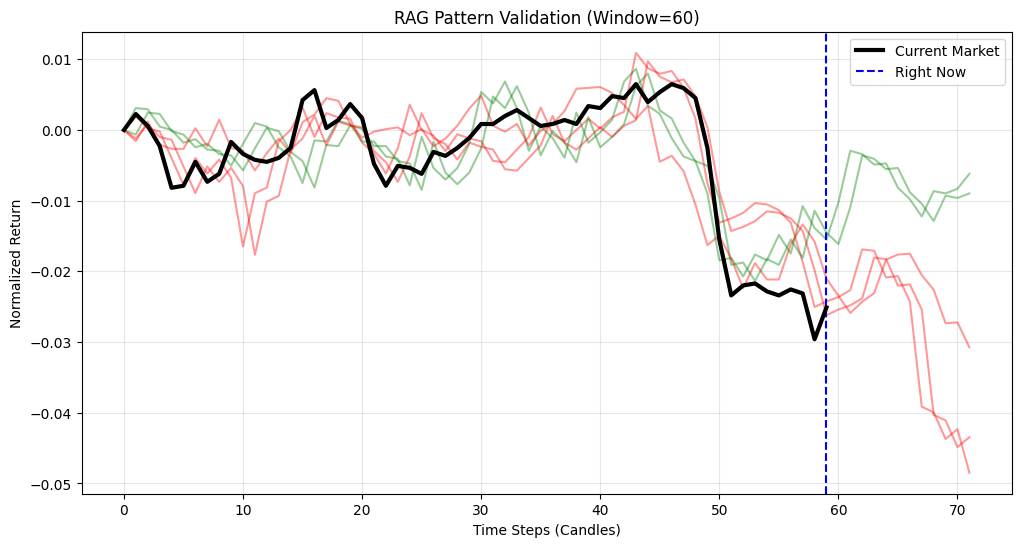

In [21]:
plot_rag_validation(current_live_window, matches)